In [ ]:
import sys, os
sys.path.insert(0, os.path.abspath('..'))

import pandas as pd
import torch
import numpy as np
from models.ModularNetworks import PairwiseInteraction, Attention

from utils.couzin_utils import *
from utils.sim_utils import *
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal
import matplotlib.pyplot as plt
%matplotlib inline
from multiprocessing import Pool, set_start_method
from utils.train_utils import compute_wasserstein_loss, gradient_penalty
from torch.utils.data import TensorDataset, DataLoader, random_split
from utils.po_encoder_utils import *
from ema_pytorch import EMA
from pathlib import Path
from datetime import datetime

In [2]:
class Discriminator(nn.Module):
    def __init__(self, encoder, z_dim=32):
        super(Discriminator, self).__init__()
        self.encoder = encoder
        self.z_dim = z_dim
        self.input_dim = 2 * z_dim

        self.fc1 = nn.Linear(self.input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)

    def encoder_forward(self, tensor):
        states = tensor[..., :4]
        _, trans = self.encoder(states)
        batch, frames_minus_one, agent, neigh_rep = trans.shape
        feats = trans.reshape(batch * frames_minus_one * agent, neigh_rep)
        return feats, (batch, frames_minus_one, agent)

    def forward(self, tensor):
        features, shape = self.encoder_forward(tensor)
        batch, frames_minus_one, agent = shape

        params = torch.relu(self.fc1(features))
        params = torch.relu(self.fc2(params))
        params = torch.relu(self.fc3(params))
        params = self.fc4(params).squeeze(-1)

        params = params.view(batch, frames_minus_one, agent)
        scores = params.mean(dim=(1, 2))
        return scores

    def update(self, expert_batch, policy_batch, optim_dis, lambda_gp,
               noise=0, generation=None, num_generations=None):

        if noise > 0.0:
            noise_until = 0.5 * num_generations
            decay = 1.0 - (generation / noise_until)
            decay = max(0.0, decay)
            noise_term = noise * decay

            expert_batch = expert_batch.clone()
            policy_batch = policy_batch.clone()

            expert_batch = expert_batch + torch.randn_like(expert_batch) * noise_term 
            policy_batch = policy_batch + torch.randn_like(policy_batch) * noise_term

        exp_scores = self.forward(expert_batch)
        gen_scores = self.forward(policy_batch)

        grad_penalty = gradient_penalty(self, expert_batch, policy_batch)

        loss, loss_gp = compute_wasserstein_loss(exp_scores, gen_scores, lambda_gp, grad_penalty)

        optim_dis.zero_grad()
        loss_gp.backward()
        optim_dis.step()

        return {
            "dis_loss": round(loss.item(), 4),
            "dis_loss_gp": round(loss_gp.item(), 4),
            "grad_penalty": round(grad_penalty.item(), 4),
            "expert_score_mean": round(exp_scores.mean().item(), 4),
            "policy_score_mean": round(gen_scores.mean().item(), 4),
        }

    def set_parameters(self, init=True):
        if init is True:
            for layer in self.modules():
                if hasattr(layer, 'reset_parameters'):
                    layer.reset_parameters()


In [3]:
class ModularPolicy(nn.Module):
    def __init__(self, features=4):
        super(ModularPolicy, self).__init__()

        self.pairwise = PairwiseInteraction(features)
        self.attention = Attention(features)

    def forward(self, states, deterministic=True):
        mu, sigma = self.pairwise(states)

        weights_logit = self.attention(states)
        weights = torch.softmax(weights_logit, dim=1)

        if deterministic:
            scaled_action = torch.sigmoid(mu)
            action = (scaled_action * weights).sum(dim=1)
            return action
        else:
            action = Normal(mu, sigma).rsample()
            scaled_action = torch.sigmoid(action)
            action = (scaled_action * weights).sum(dim=1)
            return action
        
    def set_parameters(self, init=True):
        if init is True:
            for layer in self.modules():
                if hasattr(layer, 'reset_parameters'):
                    layer.reset_parameters()

In [4]:
#https://github.com/yiftachbeer/mmd_loss_pytorch/blob/master/mmd_loss.py

class RBF(nn.Module):

    def __init__(self, n_kernels=5, mul_factor=2.0, bandwidth=None):
        super().__init__()
        self.register_buffer(
            "bandwidth_multipliers",
            mul_factor ** (torch.arange(n_kernels) - n_kernels // 2)
        )
        self.bandwidth = bandwidth
        
    def get_bandwidth(self, L2_distances):
        if self.bandwidth is None:
            n_samples = L2_distances.shape[0]
            return L2_distances.data.sum() / (n_samples ** 2 - n_samples)
        return torch.as_tensor(self.bandwidth, device=L2_distances.device, dtype=L2_distances.dtype)

    def forward(self, X):
        L2_distances = torch.cdist(X, X) ** 2
        return torch.exp(-L2_distances[None, ...] / (self.get_bandwidth(L2_distances) * self.bandwidth_multipliers)[:, None, None]).sum(dim=0)


class MMDLoss(nn.Module):

    def __init__(self, encoder, kernel=RBF()):
        super().__init__()
        self.encoder = encoder
        self.kernel = kernel

    def encode_transitions(self, tensor):
        states = tensor[..., :4]
        _, transitions = self.encoder(states)
        features = transitions.reshape(-1, transitions.size(-1))
        return features

    def forward(self, expert_batch, generative_batch):
        X = self.encode_transitions(expert_batch)
        Y = self.encode_transitions(generative_batch)

        K = self.kernel(torch.vstack([X, Y]))

        X_size = X.shape[0]
        XX = K[:X_size, :X_size].mean()
        XY = K[:X_size, X_size:].mean()
        YY = K[X_size:, X_size:].mean()
        mmd_loss = XX - 2 * XY + YY
        return mmd_loss

In [5]:
def gradient_estimate(theta, rewards_norm, epsilons, sigma, lr, num_perturbations,
                      rel_clip=0.01, abs_clip=None, min_clip=1e-12, return_metrics=True):

    grad = torch.zeros_like(theta)
    for eps, reward in zip(epsilons, rewards_norm):
        grad += eps * reward

    delta_raw = (lr / (2 * sigma**2 * num_perturbations)) * grad  
    delta_raw_norm = delta_raw.norm().clamp_min(1e-12)        

    theta_norm = theta.norm().clamp_min(1e-12)
    max_delta_norm = rel_clip * theta_norm

    if abs_clip is not None:
        max_delta_norm = torch.minimum(max_delta_norm, theta.new_tensor(abs_clip))
    max_delta_norm = torch.maximum(max_delta_norm, theta.new_tensor(min_clip))

    clip_ratio = (max_delta_norm / delta_raw_norm).clamp(max=1.0)
    delta = delta_raw * clip_ratio 

    theta_new = theta + delta

    if return_metrics:
        return theta_new, {
            "theta_norm": float(theta_norm.item()),
            "delta_raw_norm": float(delta_raw_norm.item()),
            "delta_norm": float(delta.norm().item()),
            "max_delta_norm": float(max_delta_norm.item()),
            "clip_ratio": float(clip_ratio.item()),
        }

    return theta_new



def discriminator_reward(discriminator, gen_tensor):
    scores = discriminator(gen_tensor)
    return scores.mean()


def optimize_es(policy, module, discriminator, lr, sigma, num_perturbations, device="cuda", init_pool=None):

    network = policy.pairwise if module == 'pairwise' else policy.attention
    
    theta = nn.utils.parameters_to_vector(network.parameters()).detach().clone()
    dim = theta.numel()

    seeds = np.random.randint(0, 100000, size=num_perturbations)

    reward_diffs = []
    epsilons = []

    for perturbation in range(num_perturbations):

        seed = seeds[perturbation]

        eps = torch.randn(dim, device=theta.device, dtype=theta.dtype) * sigma
        epsilons.append(eps)

        with torch.no_grad():
            nn.utils.vector_to_parameters(theta + eps, network.parameters())
            _, pos_prey_tensor = run_env_simulation(visualization='off', prey_policy=policy, pred_policy=None,
                                                    n_prey=32, n_pred=0, 
                                                    max_steps=100, seed=seed,
                                                    pred_speed=5, prey_speed=5,
                                                    area_width=50, area_height=50, 
                                                    init_pool=init_pool)
            pos_prey_tensor = pos_prey_tensor.unsqueeze(0).to(device=device)
            pos_reward = discriminator_reward(discriminator, pos_prey_tensor)

            nn.utils.vector_to_parameters(theta - eps, network.parameters())
            _, neg_prey_tensor = run_env_simulation(visualization='off', prey_policy=policy, pred_policy=None,
                                                    n_prey=32, n_pred=0, 
                                                    max_steps=100, seed=seed,
                                                    pred_speed=5, prey_speed=5,
                                                    area_width=50, area_height=50,
                                                    init_pool=init_pool)
            neg_prey_tensor = neg_prey_tensor.unsqueeze(0).to(device=device)
            neg_reward = discriminator_reward(discriminator, neg_prey_tensor)

            nn.utils.vector_to_parameters(theta, network.parameters())

            reward_diffs.append((pos_reward.mean() - neg_reward.mean()).detach())

    diffs = torch.stack(reward_diffs)
    #rewards_norm = (diffs - diffs.mean()) / (diffs.std(unbiased=False) + 1e-8)
    ranks = torch.argsort(torch.argsort(diffs)).float()
    ranks_norm = (ranks - ranks.mean()) / (ranks.std() + 1e-8)

    theta_est, grad_metrics = gradient_estimate(theta, ranks_norm, epsilons, sigma, lr, num_perturbations)

    # if std is too small, do not update (Random Walk)
    if diffs.std(unbiased=False) < 1e-6:
        theta_est = theta

    nn.utils.vector_to_parameters(theta_est, network.parameters())
    
    return {"diff_min": round(diffs.min().item(), 6),
            "diff_max": round(diffs.max().item(), 6),
            "diff_mean": round(diffs.mean().item(), 6),
            "diff_std": round(diffs.std(unbiased=False).item(), 6),
            "delta_norm": round((theta_est - theta).norm().item(), 6),
            "clip_ratio": round(grad_metrics["clip_ratio"], 6),
            "delta_raw_norm": round(grad_metrics["delta_raw_norm"], 6),
            "max_delta_norm": round(grad_metrics["max_delta_norm"], 6)
        }


def mae_actions(expert_batch, generative_batch):
    a_exp = expert_batch[..., 4]
    a_gen = generative_batch[..., 4]
    return torch.mean(torch.abs(a_exp - a_gen)).item()


def pretrain_policy(policy, expert_data, batch_size=256, epochs=250, lr=1e-3, deterministic=True, device='cuda'):
    policy.train()

    optimizer = torch.optim.Adam(policy.parameters(), lr=lr)

    frames, agents, neigh, features = expert_data.shape
    expert_data = expert_data.reshape(frames * agents, neigh, features)
    
    states = expert_data[..., :4]
    actions = expert_data[:, 0, 4]

    dataset = TensorDataset(states, actions)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(1, epochs + 1):
        epoch_loss = 0

        for states, actions in loader:
            states = states.to(device=device)
            actions = actions.to(device=device)
            
            action = policy.forward(states, deterministic=deterministic)

            if action.dim() == 2 and action.size(-1) == 1:
                action = action.squeeze(-1) 

            loss = F.mse_loss(action, actions)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * actions.size(0)

        if epoch % 25 == 0:
            print(f"Epoch {epoch}/{epochs}, Loss: {epoch_loss / (frames * agents):.6f}")

    return policy

In [ ]:
# Expert
max_steps = 500

# Training
num_generations = 200
gamma = 0.999

# Policy
lr_policy = 5e-4
num_perturbations = 64
sigma = 0.1
deterministic=True

# Discriminator
dis_balance_factor = 5
noise = 0.002
lr_disc = 2e-4
lambda_gp = 5

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
#%matplotlib tk
'''_, exp_tensor, _, init_pool = run_couzin_simulation(visualization="off", max_steps=max_steps, alpha=0.01, 
                                         constant_speed=5, shark_speed=5, 
                                         area_width=50, area_height=50,
                                         number_of_sharks=0, n=32)'''

_, exp_tensor, _, init_pool = run_circular_simulation(visualization="off", max_steps=max_steps)

In [ ]:
aug = TrajectoryAugmentation(noise_std=0.01, neigh_drop=0.10, feat_drop=0.05).to(device)
encoder = TransitionEncoder(features=4, embd_dim=32, z=32).to(device)
projector = VicRegProjector(input_dim=64).to(device)
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(projector.parameters()), lr=1e-3, weight_decay=1e-6)

train_encoder(encoder, projector, aug=aug, exp_tensor=exp_tensor, epochs=1500, optimizer=optimizer)

epoch 010: loss=24.372274 sim=0.0611 std=1.4330 cov=0.2698 std_mean=0.284
epoch 020: loss=23.520443 sim=0.0492 std=1.3744 cov=0.3347 std_mean=0.313
epoch 030: loss=22.915604 sim=0.0367 std=1.3194 cov=0.4415 std_mean=0.340
epoch 040: loss=22.276840 sim=0.0329 std=1.2827 cov=0.4425 std_mean=0.359
epoch 050: loss=21.928642 sim=0.0290 std=1.2482 cov=0.4962 std_mean=0.376
epoch 060: loss=21.578707 sim=0.0266 std=1.2332 cov=0.4831 std_mean=0.383
epoch 070: loss=21.407143 sim=0.0251 std=1.2076 cov=0.5335 std_mean=0.396
epoch 080: loss=21.159616 sim=0.0248 std=1.2054 cov=0.4916 std_mean=0.397
epoch 090: loss=20.935604 sim=0.0281 std=1.1694 cov=0.5383 std_mean=0.415
epoch 100: loss=20.845232 sim=0.0287 std=1.1491 cov=0.5782 std_mean=0.425
epoch 110: loss=20.808897 sim=0.0273 std=1.1536 cov=0.5641 std_mean=0.423
epoch 120: loss=20.780472 sim=0.0259 std=1.1544 cov=0.5630 std_mean=0.423
epoch 130: loss=20.684795 sim=0.0240 std=1.1536 cov=0.5562 std_mean=0.423
epoch 140: loss=20.675480 sim=0.0238 s

In [ ]:
policy = ModularPolicy().to(device)
policy.set_parameters(init=True)
#pretrain_policy(policy, expert_data=exp_tensor, batch_size=4048, epochs=300, lr=1e-3,
#                deterministic=deterministic, device=device)
#print("Pretraining done.\n")

ema = EMA(policy, beta=0.9999, update_after_step=10, update_every=5, allow_different_devices=True)

In [ ]:
# Mean MMD: 0.036720 ± 0.033579
mmd_loss = MMDLoss(encoder=encoder).to(device)
discriminator = Discriminator(encoder=encoder, z_dim=32).to(device)
discriminator.set_parameters(init=True)
optim_disc = torch.optim.RMSprop(discriminator.parameters(), lr=lr_disc, alpha=0.99, eps=1e-08)

for p in encoder.parameters():
    p.requires_grad = False 

mmd_list = []
policy_metrics_list = []
disc_metrics_list = []

for gen in range(num_generations):
    rollout_policy = ema.ema_model.to("cpu")
    
    _, gen_prey_tensor = run_env_simulation(
        visualization='off', prey_policy=rollout_policy, pred_policy=None,
        n_prey=32, n_pred=0, max_steps=500,
        pred_speed=5, prey_speed=5,
        area_width=50, area_height=50, init_pool=init_pool)

    for i in range(dis_balance_factor):
        expert_batch = sample_data(exp_tensor, consecutive_frames=10, batch_size=10).to(device)
        generative_batch = sample_data(gen_prey_tensor, consecutive_frames=10, batch_size=10).to(device)

        dis_metric = discriminator.update(expert_batch, generative_batch, optim_disc, lambda_gp,
                                          noise=noise, generation=gen, num_generations=num_generations)
        disc_metrics_list.append(dis_metric)
        

    pin_metrics = optimize_es(policy, "pairwise", discriminator, lr=lr_policy, sigma=sigma,
                             num_perturbations=num_perturbations, init_pool=init_pool)
    
    an_metrics  = optimize_es(policy, "attention", discriminator, lr=lr_policy, sigma=sigma,
                             num_perturbations=num_perturbations, init_pool=init_pool)
    policy_metrics_list.append((pin_metrics, an_metrics))
    
    
    ema.update()

    sigma *= gamma
    lr_policy *= gamma

    with torch.no_grad():
        mmd_metric = mmd_loss.forward(expert_batch, generative_batch)
    mmd_list.append(mmd_metric.item())

    current_state = ema.ema_model.state_dict()

    if gen == 0:
        best_val = mmd_metric
        best_policy_state = {key: value.detach().clone() for key, value in current_state.items()}
    elif mmd_metric < best_val:
        best_val = mmd_metric
        print("New best MMD:", best_val.item())
        best_policy_state = {key: value.detach().clone() for key, value in current_state.items()}

    print("Generation", gen+1)
    print(f"PIN Network:   {pin_metrics}")
    print(f"AN Network:    {an_metrics}")
    print(f"Discriminator: {dis_metric}")
    print(f"MMD: {mmd_metric} | Score Diff: {abs(dis_metric['expert_score_mean'] - dis_metric['policy_score_mean'])}\n")

policy.load_state_dict(best_policy_state, strict=True)


Generation 1
PIN Network:   {'diff_min': -1.9e-05, 'diff_max': 1.6e-05, 'diff_mean': 1e-06, 'diff_std': 9e-06, 'delta_norm': 0.073536, 'clip_ratio': 0.704085, 'delta_raw_norm': 0.104442, 'max_delta_norm': 0.073536}
AN Network:    {'diff_min': -1.1e-05, 'diff_max': 9e-06, 'diff_mean': 0.0, 'diff_std': 5e-06, 'delta_norm': 0.071583, 'clip_ratio': 0.701539, 'delta_raw_norm': 0.102038, 'max_delta_norm': 0.071583}
Discriminator: {'dis_loss': -0.0, 'dis_loss_gp': 9.9997, 'grad_penalty': 1.0, 'expert_score_mean': 0.0999, 'policy_score_mean': 0.0999}
MMD: 0.23056864738464355 | Score Diff: 0.0

Generation 2
PIN Network:   {'diff_min': -3.7e-05, 'diff_max': 4.8e-05, 'diff_mean': 1e-06, 'diff_std': 1.4e-05, 'delta_norm': 0.073537, 'clip_ratio': 0.703314, 'delta_raw_norm': 0.104558, 'max_delta_norm': 0.073537}
AN Network:    {'diff_min': -1.4e-05, 'diff_max': 1.2e-05, 'diff_mean': -1e-06, 'diff_std': 6e-06, 'delta_norm': 0.071599, 'clip_ratio': 0.683825, 'delta_raw_norm': 0.104704, 'max_delta_norm

<All keys matched successfully>

In [22]:
base_dir = Path(r"..\data\2. Training\training\PreyOnly - GAIL")
run_dir = base_dir / datetime.now().strftime("%Y.%m.%d_%H.%M")
run_dir.mkdir(parents=True, exist_ok=True)

save_path = run_dir / "prey_only_policy.pth"
torch.save(policy.state_dict(), save_path)

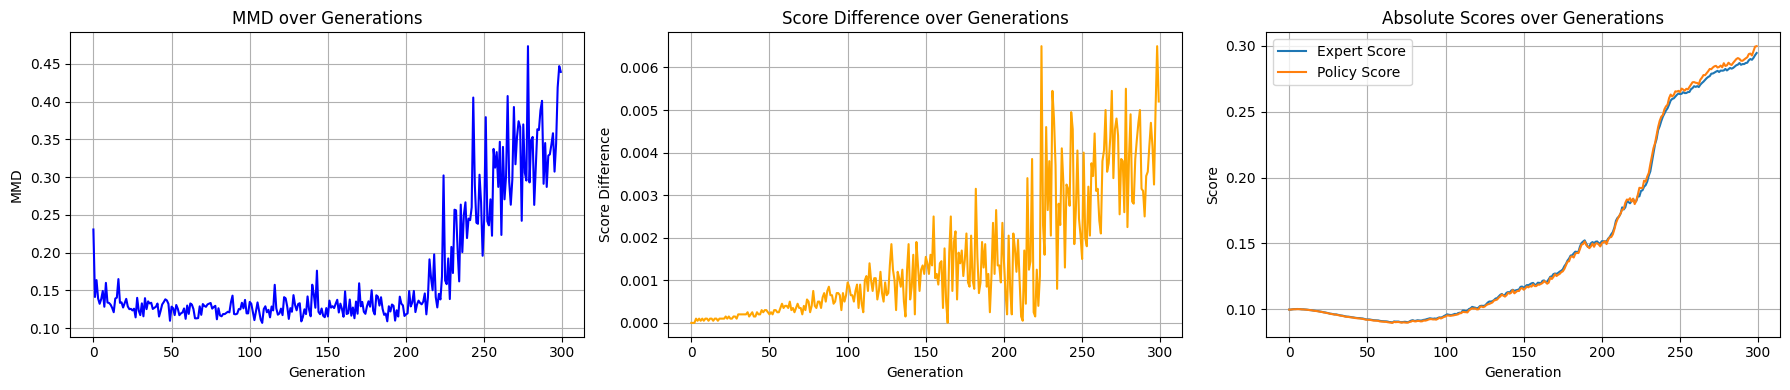

In [ ]:
gens = np.arange(len(mmd_list))

disc_df = pd.DataFrame(disc_metrics_list)
disc_df["gen"] = (disc_df.index // dis_balance_factor) + 1
disc_mean = disc_df.groupby("gen").mean(numeric_only=True).sort_index()

score_diffs = (disc_mean["expert_score_mean"] - disc_mean["policy_score_mean"]).abs().to_numpy()
abs_scores = disc_mean[["expert_score_mean", "policy_score_mean"]].to_numpy()

fig, axes = plt.subplots(1, 3, figsize=(18, 4), sharex=True)

axes[0].plot(gens, mmd_list, color="blue")
axes[0].set_xlabel("Generation")
axes[0].set_ylabel("MMD")
axes[0].set_title("MMD over Generations")
axes[0].grid(True)

axes[1].plot(gens, score_diffs, color="orange")
axes[1].set_xlabel("Generation")
axes[1].set_ylabel("Score Difference")
axes[1].set_title("Score Difference over Generations")
axes[1].grid(True)

axes[2].plot(gens, abs_scores[:, 0], label="Expert Score")
axes[2].plot(gens, abs_scores[:, 1], label="Policy Score")
axes[2].set_xlabel("Generation")
axes[2].set_ylabel("Score")
axes[2].set_title("Absolute Scores over Generations")
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()

plot_path = run_dir / "disc_metrics.png"
fig.savefig(plot_path, dpi=300, bbox_inches="tight")

plt.show()

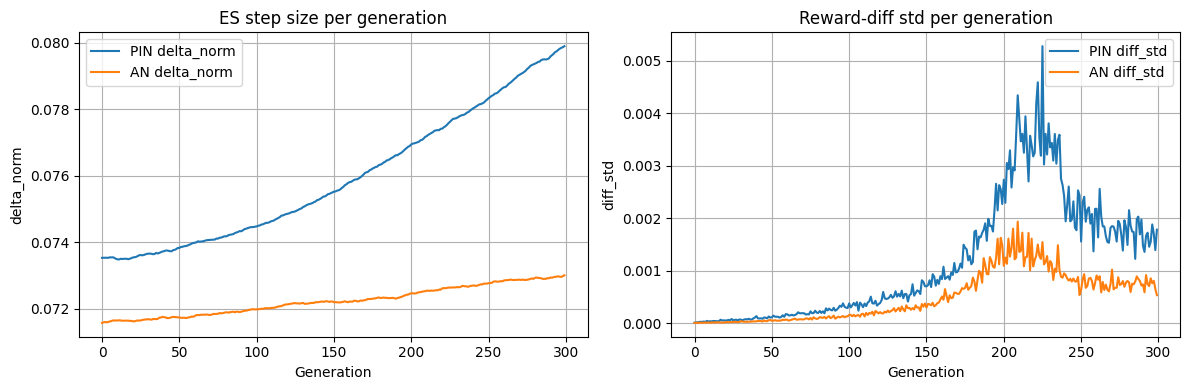

In [ ]:
pin_delta_norm = np.array([pm[0].get("delta_norm", np.nan) for pm in policy_metrics_list], dtype=float)
an_delta_norm  = np.array([pm[1].get("delta_norm", np.nan) for pm in policy_metrics_list], dtype=float)

pin_diff_std = np.array([pm[0].get("diff_std", np.nan) for pm in policy_metrics_list], dtype=float)
an_diff_std  = np.array([pm[1].get("diff_std", np.nan) for pm in policy_metrics_list], dtype=float)


fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True)

axes[0].plot(gens, pin_delta_norm, label="PIN delta_norm")
axes[0].plot(gens, an_delta_norm, label="AN delta_norm")
axes[0].set_xlabel("Generation")
axes[0].set_ylabel("delta_norm")
axes[0].set_title("ES step size per generation")
axes[0].legend()
axes[0].grid(True)

axes[1].plot(gens, pin_diff_std, label="PIN diff_std")
axes[1].plot(gens, an_diff_std, label="AN diff_std")
axes[1].set_xlabel("Generation")
axes[1].set_ylabel("diff_std")
axes[1].set_title("Reward-diff std per generation")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()

plot_path = run_dir / "es_metrics.png"
fig.savefig(plot_path, dpi=300, bbox_inches="tight")

plt.show()

In [26]:
%matplotlib tk
_, gen_prey_tensor = run_env_simulation(visualization='on', prey_policy=policy, pred_policy=None,
        n_prey=32, n_pred=0, max_steps=200,
        pred_speed=5, prey_speed=5,
        area_width=50, area_height=50)

In [ ]:
%matplotlib tk
_, exp_tensor, _ = run_couzin_simulation(visualization="on", max_steps=100, alpha=0.01, 
                                         constant_speed=5, shark_speed=5, 
                                         area_width=50, area_height=50,
                                         number_of_sharks=0, n=32)

ValueError: too many values to unpack (expected 3)